In [1]:
import sys, os
import torch
import numpy as np 
import pandas as pd
sys.path.append("./src")
import scdisinfact
import utils
import bmk

import matplotlib.pyplot as plt

from umap import UMAP
from sklearn.decomposition import PCA
import scipy.sparse as sp
import warnings
import time
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Load the dataset
We used the simulated dataset with 6 batches and 2 condition types: 
* groups in type 1: ctrl, stim
* groups in type 2: healthy, mild, severe

We selected the count matrices for the six batches under conditions:
* **Batch 1**: ctrl, healthy
* **Batch 2**: ctrl, mild
* **Batch 3**: ctrl, severe
* **Batch 4**: stim, healthy
* **Batch 5**: stim, mild
* **Batch 6**: stim, severe

We then create the input count matrices and its corresponding meta_data

In [2]:
from numpy import concatenate


data_dir = f"./data/simulated/2conditions_10000_500_0.4_20_2/"
result_dir = f"./demo_result/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

label_annos = []
label_batches = []

counts_gt = []
counts_ctrl_healthy = []
counts_ctrl_mild = []
counts_ctrl_severe = []
counts_stim_healthy = []
counts_stim_mild = []
counts_stim_severe = []

np.random.seed(0)
# loop through data batches and read the count matrices
for batch_id in range(6):
    counts_gt.append(pd.read_csv(data_dir + f'GxC{batch_id + 1}_true.txt', sep = "\t", header = None).values.T)
    
    counts_ctrl_healthy.append(pd.read_csv(data_dir + f'GxC{batch_id + 1}_ctrl_healthy.txt', sep = "\t", header = None).values.T)
    counts_ctrl_mild.append(pd.read_csv(data_dir + f'GxC{batch_id + 1}_ctrl_mild.txt', sep = "\t", header = None).values.T)
    counts_ctrl_severe.append(pd.read_csv(data_dir + f'GxC{batch_id + 1}_ctrl_severe.txt', sep = "\t", header = None).values.T)
    counts_stim_healthy.append(pd.read_csv(data_dir + f'GxC{batch_id + 1}_stim_healthy.txt', sep = "\t", header = None).values.T)
    counts_stim_mild.append(pd.read_csv(data_dir + f'GxC{batch_id + 1}_stim_mild.txt', sep = "\t", header = None).values.T)
    counts_stim_severe.append(pd.read_csv(data_dir + f'GxC{batch_id + 1}_stim_severe.txt', sep = "\t", header = None).values.T)

    anno = pd.read_csv(data_dir + f'cell_label{batch_id + 1}.txt', sep = "\t", index_col = 0).values.squeeze()
    # annotation labels
    label_annos.append(np.array([('cell type '+str(i)) for i in anno]))
    # batch labels
    label_batches.append(np.array(['batch ' + str(batch_id)] * counts_ctrl_healthy[-1].shape[0]))

# create the training dataset
label_cond1 = ["healthy"] * counts_ctrl_healthy[0].shape[0] + ["mild"] * counts_ctrl_healthy[1].shape[0] + ["severe"] * counts_ctrl_healthy[2].shape[0] \
    + ["healthy"] * counts_ctrl_healthy[3].shape[0] + ["mild"] * counts_ctrl_healthy[4].shape[0] + ["severe"] * counts_ctrl_healthy[5].shape[0]

label_cond2 = ["ctrl"] * (counts_ctrl_healthy[0].shape[0] + counts_ctrl_healthy[1].shape[0] + counts_ctrl_healthy[2].shape[0]) \
    + ["stim"] * (counts_ctrl_healthy[3].shape[0] + counts_ctrl_healthy[4].shape[0] + counts_ctrl_healthy[5].shape[0])

counts = [counts_ctrl_healthy[0], counts_ctrl_mild[1], counts_ctrl_severe[2], counts_stim_healthy[3], counts_stim_mild[4], counts_stim_severe[5]]


# reformat for the input of scDisInFact, cell types is optional
meta_cells = pd.DataFrame(columns = ["batch", "condition_type_1", "condition_type_2", "cell_type"])
meta_cells["batch"] = np.concatenate(label_batches, axis = 0)
meta_cells["condition_type_1"] = np.array(label_cond1)
meta_cells["condition_type_2"] = np.array(label_cond2)
meta_cells["cell_type"] = np.concatenate(label_annos, axis = 0)

counts = np.concatenate(counts, axis = 0)

gene_names = np.array(["gene_" + str(i) for i in range(500)])

## Create scDisInFact dataset

Given the count matrix (list of count matrices where one may correspond to one batch), the meta_cell dataframe (list of dataframe that matches the list of count matrices), and gene names, scDisInFact create training dataset using function `scdisinfact.create_scdisinfact_dataset()`

In [3]:
datasets_array, meta_cells_array, matching_dict = scdisinfact.create_scdisinfact_dataset(counts, meta_cells, condition_key = ["condition_type_1", "condition_type_2"], batch_key = "batch", batch_cond_key = None, meta_genes = gene_names)


Sanity check...
Finished.
Create scDisInFact datasets...
Finished.


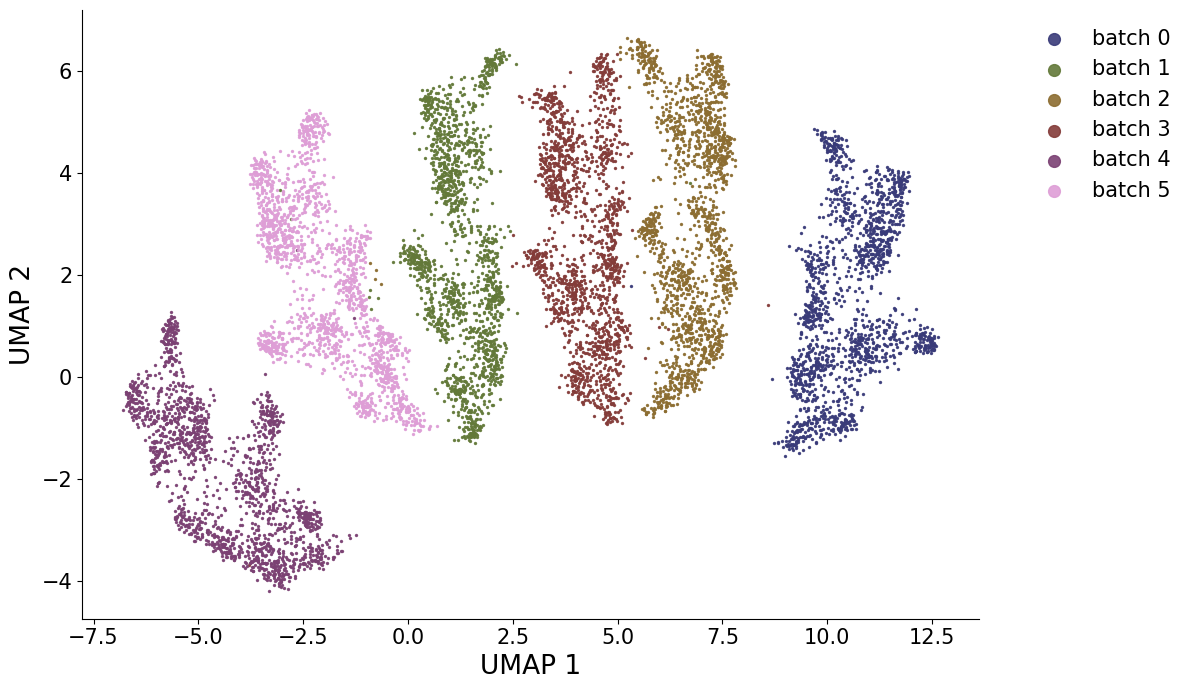

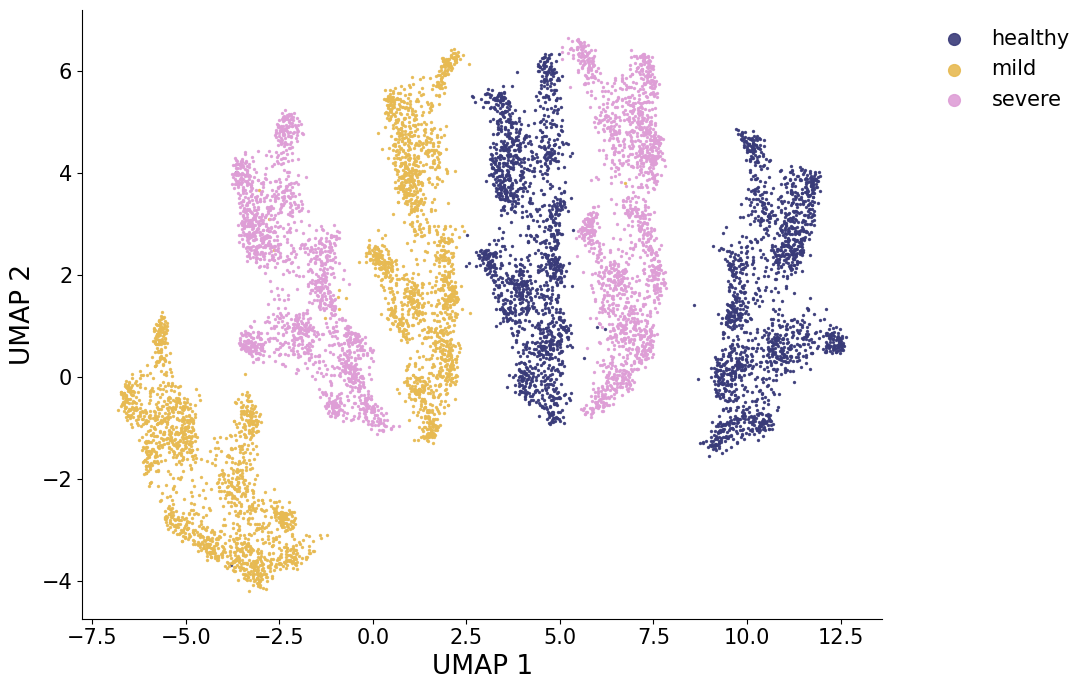

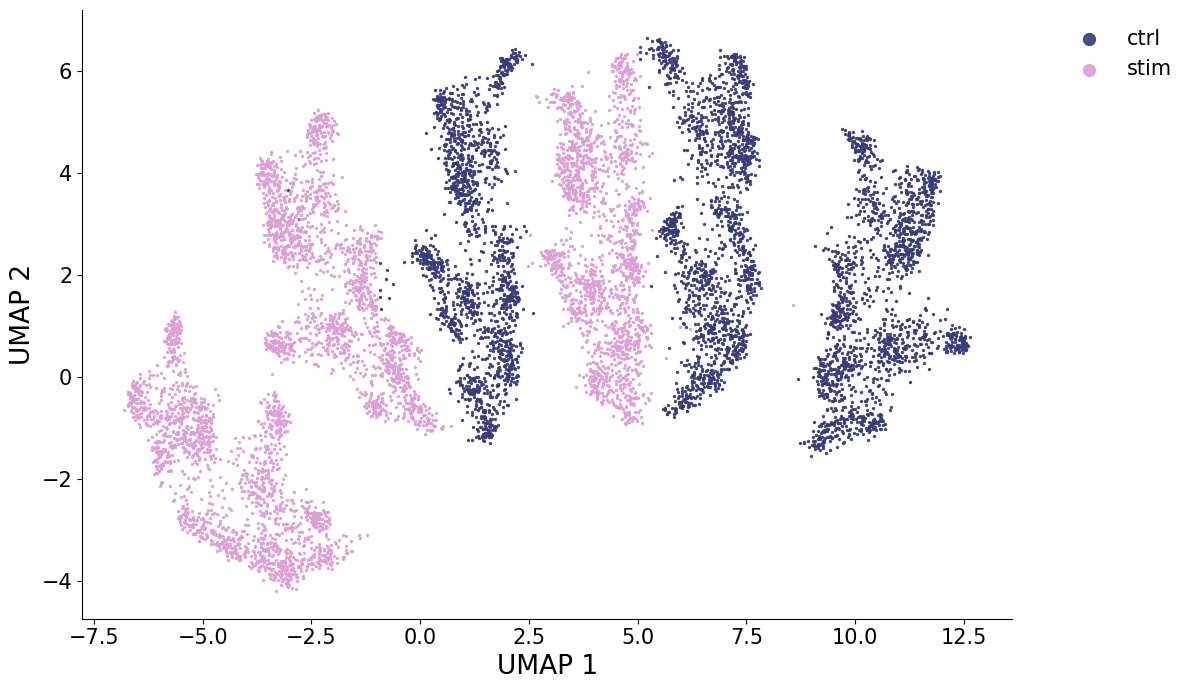

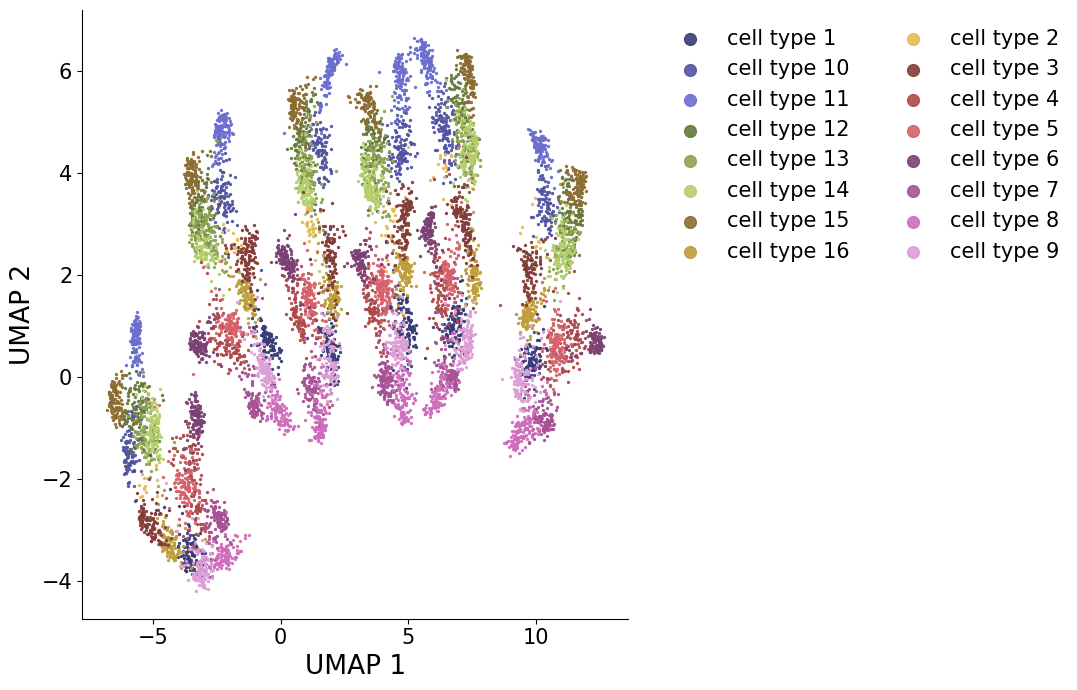

In [4]:

# Visualize the raw gene expression data
umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0) 

x_pca = PCA(n_components = 80).fit_transform(np.concatenate([x.counts_norm for x in datasets_array], axis = 0))
x_umap = umap_op.fit_transform(x_pca)
# separate into batches
x_umaps = []
for batch, _ in enumerate(meta_cells_array):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + meta_cells_array[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (len(meta_cells_array) - 1):
        start_pointer = start_pointer + meta_cells_array[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + meta_cells_array[batch - 1].shape[0]
        end_pointer = start_pointer + meta_cells_array[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

save_file = None

utils.plot_latent(x_umaps, annos = [x["batch"].values.squeeze() for x in meta_cells_array], mode = "joint", save = result_dir + "batches.png", figsize = (12,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umaps, annos = [x["condition_type_1"].values.squeeze() for x in meta_cells_array], mode = "joint", save = result_dir + "condition_type_1.png", figsize = (11,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umaps, annos = [x["condition_type_2"].values.squeeze() for x in meta_cells_array], mode = "joint", save = result_dir + "condition_type_2.png", figsize = (12,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umaps, annos = [x["cell_type"].values.squeeze() for x in meta_cells_array], mode = "joint", save = result_dir + "celltypes.png", figsize = (11,7), axis_label = "UMAP", markerscale = 6, s = 2)


## Training scDisInFact
We use the default hyper-parameter setting

In [5]:
# hyper-parameter setting
reg_mmd_comm = 1e-4
reg_mmd_diff = 1e-4
reg_gl = 1
reg_tc = 0.5
reg_class = 1
reg_kl = 1e-6
lambs = [reg_mmd_comm, reg_mmd_diff, reg_class, reg_gl, reg_tc, reg_kl]
Ks = [8, 4, 4]
nepochs = 50
interval = 10

# training process
model = scdisinfact.scdisinfact(datasets = datasets_array, Ks = Ks, batch_size = 64, interval = interval, lr = 5e-4, 
                                reg_mmd_comm = reg_mmd_comm, reg_mmd_diff = reg_mmd_diff, reg_gl = reg_gl, reg_tc = reg_tc, 
                                reg_kl = reg_kl, reg_class = reg_class, seed = 0, device = device)

losses = model.train_model(nepochs = nepochs, recon_loss = "NB", reg_contr = 0.01)

torch.save(model.state_dict(), result_dir + f"model_{Ks}_{lambs}.pth")
model.load_state_dict(torch.load(result_dir + f"model_{Ks}_{lambs}.pth", map_location = device))
end_time = time.time()

test dataset shrink to 100
test dataset shrink to 100
test dataset shrink to 100
test dataset shrink to 100
test dataset shrink to 100
test dataset shrink to 100
Epoch 0, Validating Loss: 12.4560
	 loss reconstruction: 1.80417
	 loss kl: 3459.17188
	 loss mmd common: 0.65350
	 loss mmd diff: 0.88085
	 loss classification: 1.83893
	 loss contrastive: 791.53979
	 loss group lasso diff: 0.54070
	 loss total correlation (disc): 0.70634
GPU memory usage: 12.852051MB
Epoch 10, Validating Loss: 5.1365
	 loss reconstruction: 1.55255
	 loss kl: 36741.89844
	 loss mmd common: 0.83050
	 loss mmd diff: 1.17532
	 loss classification: 0.86063
	 loss contrastive: 174.99261
	 loss group lasso diff: 0.58974
	 loss total correlation (disc): 0.69332
GPU memory usage: 12.852051MB
Epoch 20, Validating Loss: 3.8428
	 loss reconstruction: 1.52098
	 loss kl: 42989.21875
	 loss mmd common: 0.78797
	 loss mmd diff: 1.30939
	 loss classification: 0.15412
	 loss contrastive: 121.27807
	 loss group lasso diff: 0.5

## Visualize shared-bio and unshared-bio factors
After training the model, we extracted the shared-bio and unshared-bio factors from the encoder output.

To conduct forward pass on a test dataset, two functions are needed:
* `model.inference()`: infer the latent factor from the gene expression data (encoder)
* `model.generate()`: generate the gene expression data from the latent factors (decoder)

In [6]:
# forward pass on scDisInFact
z_cs = []
z_ds = []
zs = []

for dataset in datasets_array:
    with torch.no_grad():
        # pass through the encoders
        dict_inf = model.inference(counts = dataset.counts_stand.to(model.device), batch_ids = dataset.batch_id[:,None].to(model.device), print_stat = True, eval_model = True)
        # pass through the decoder
        dict_gen = model.generative(z_c = dict_inf["mu_c"], z_d = dict_inf["mu_d"], batch_ids = dataset.batch_id[:,None].to(model.device))
        z_c = dict_inf["mu_c"]
        z_d = dict_inf["mu_d"]
        z = torch.cat([z_c] + z_d, dim = 1)
        mu = dict_gen["mu"]        
        z_ds.append([x.cpu().detach().numpy() for x in z_d])
        z_cs.append(z_c.cpu().detach().numpy())
        zs.append(np.concatenate([z_cs[-1]] + z_ds[-1], axis = 1))


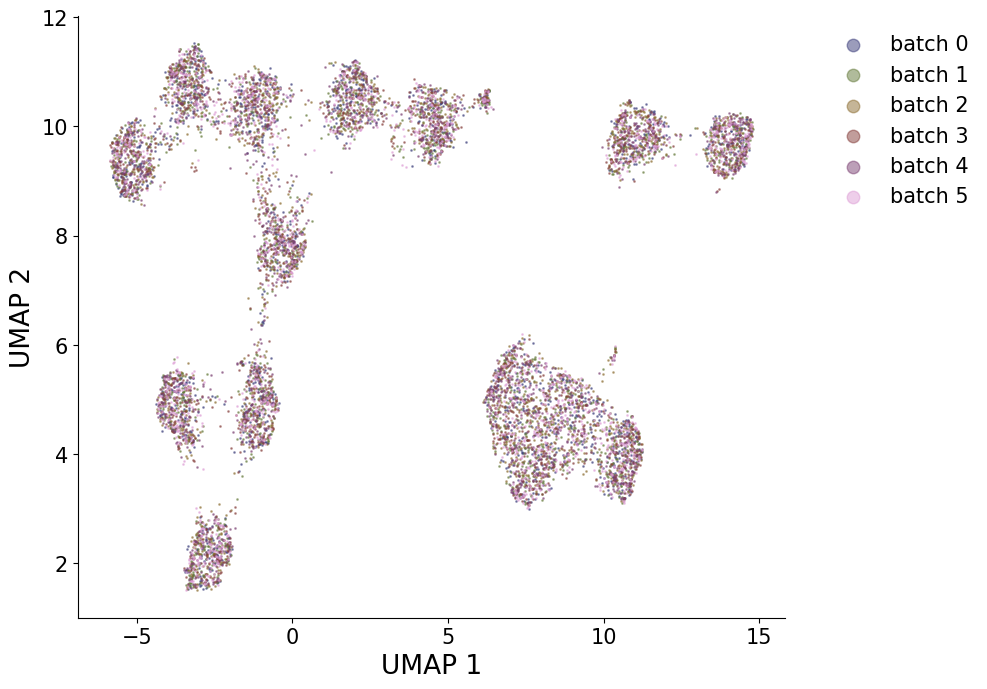

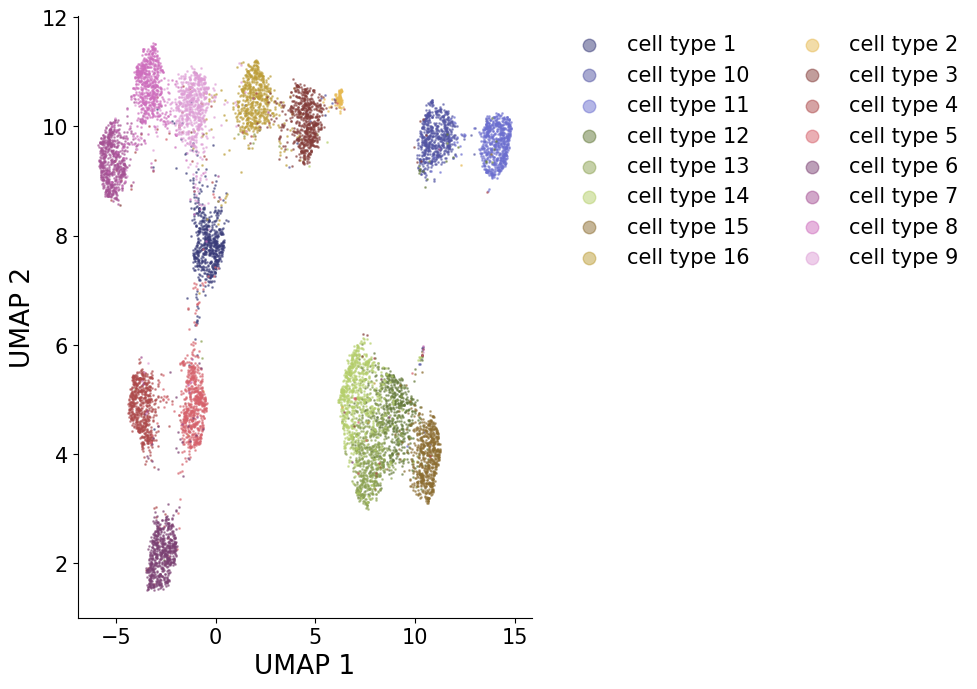

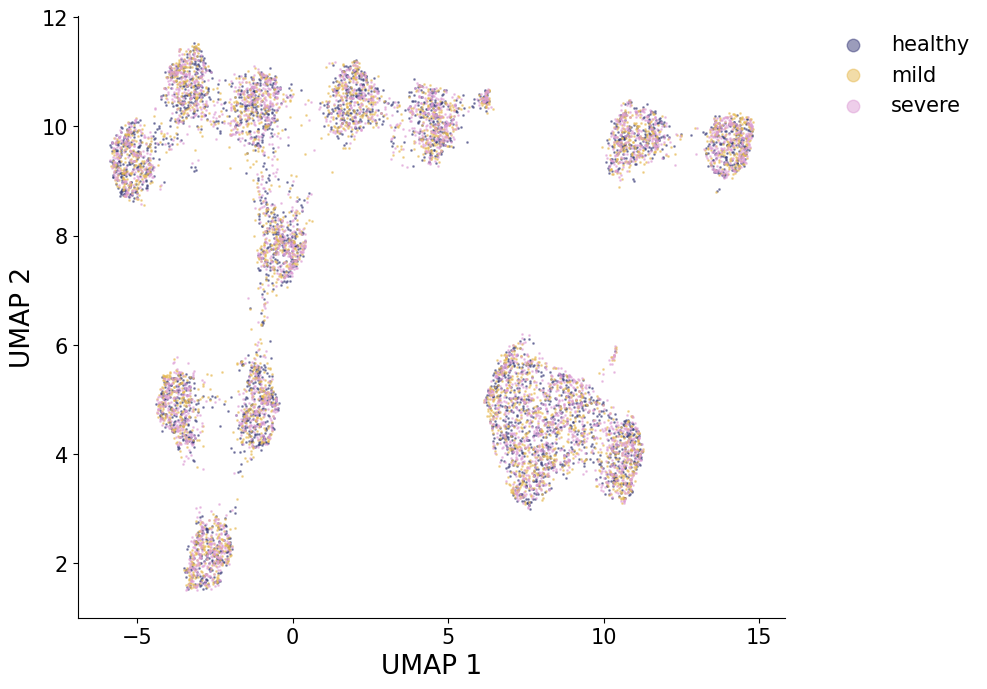

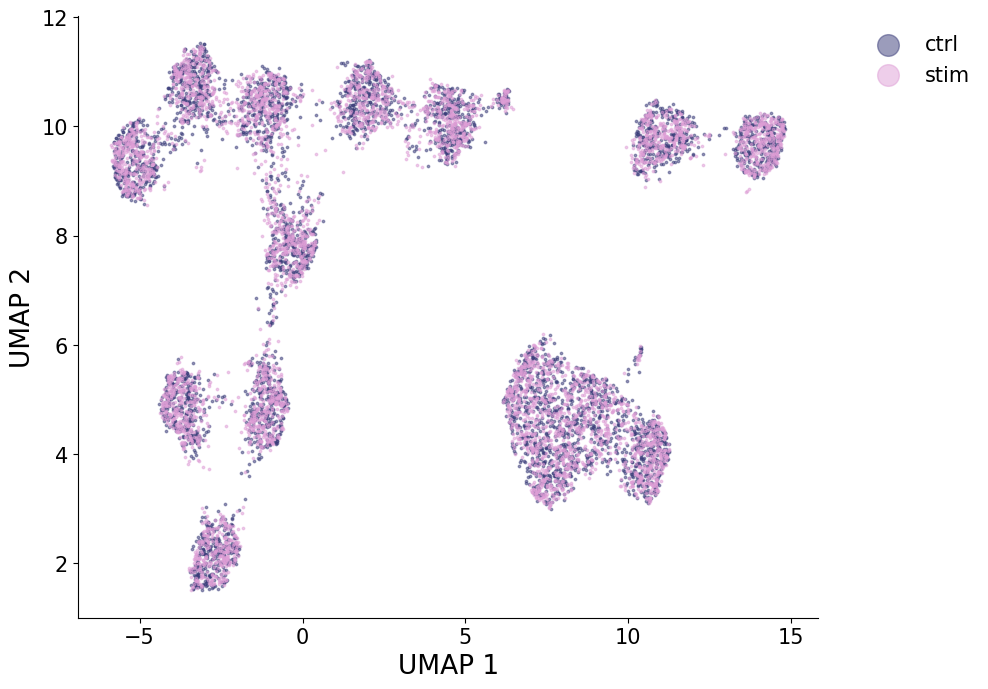

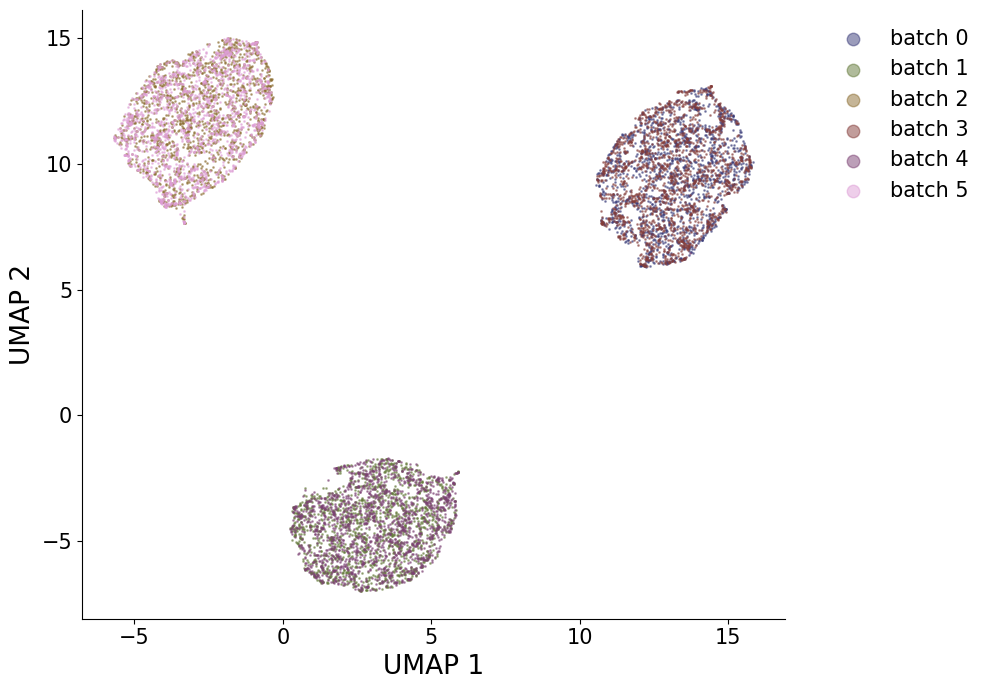

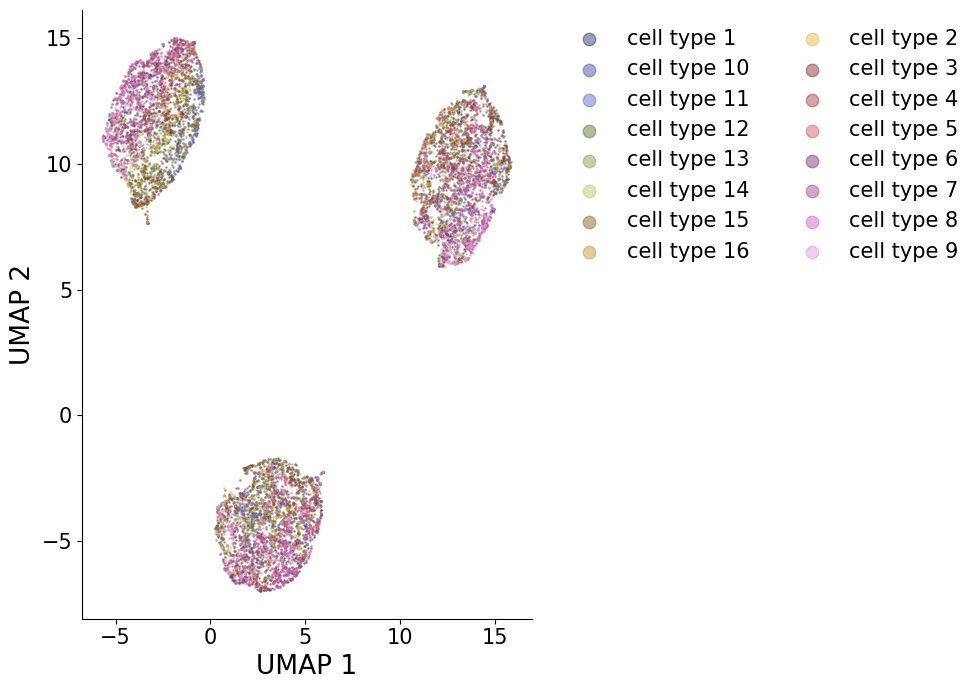

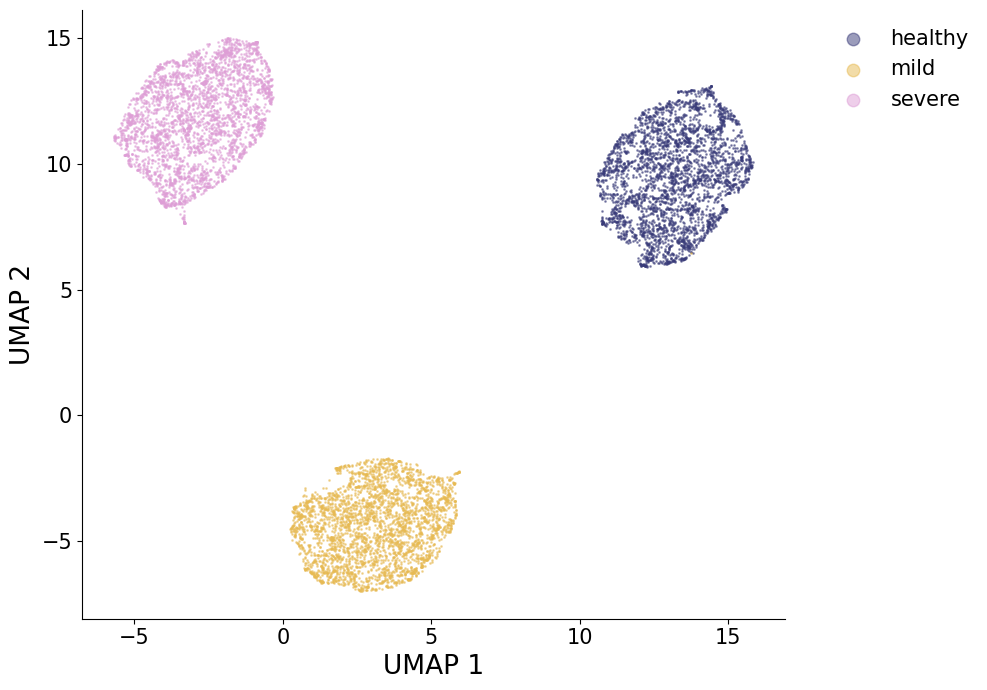

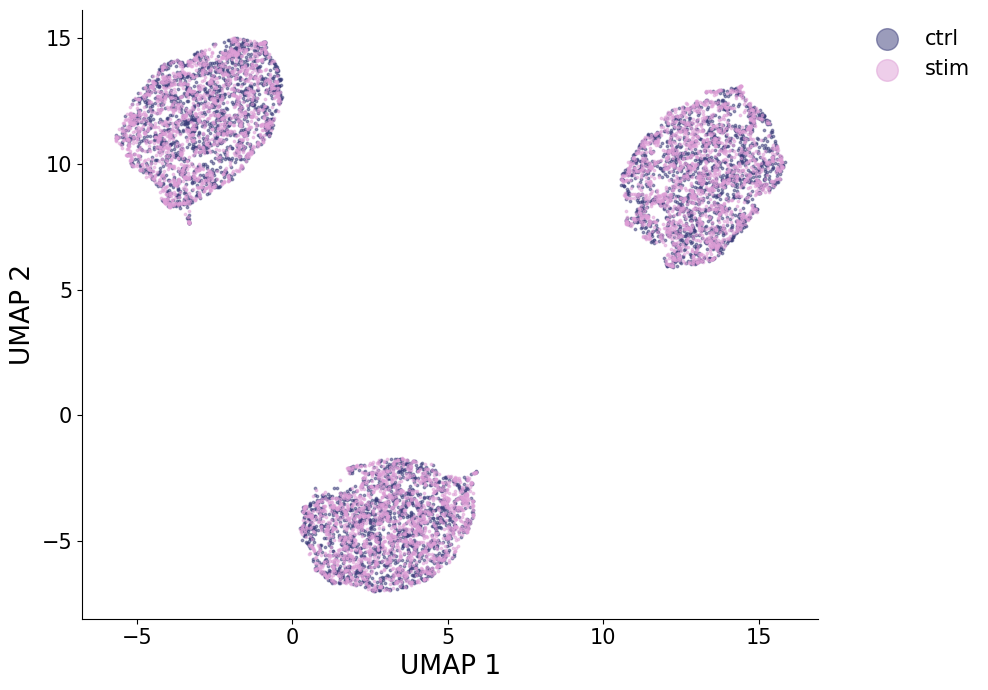

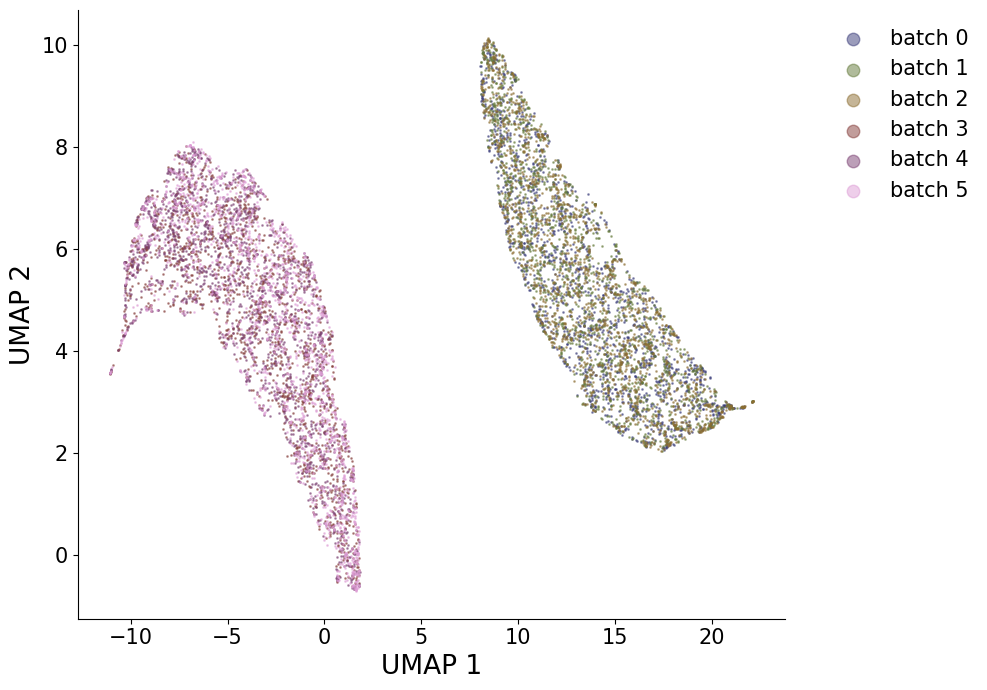

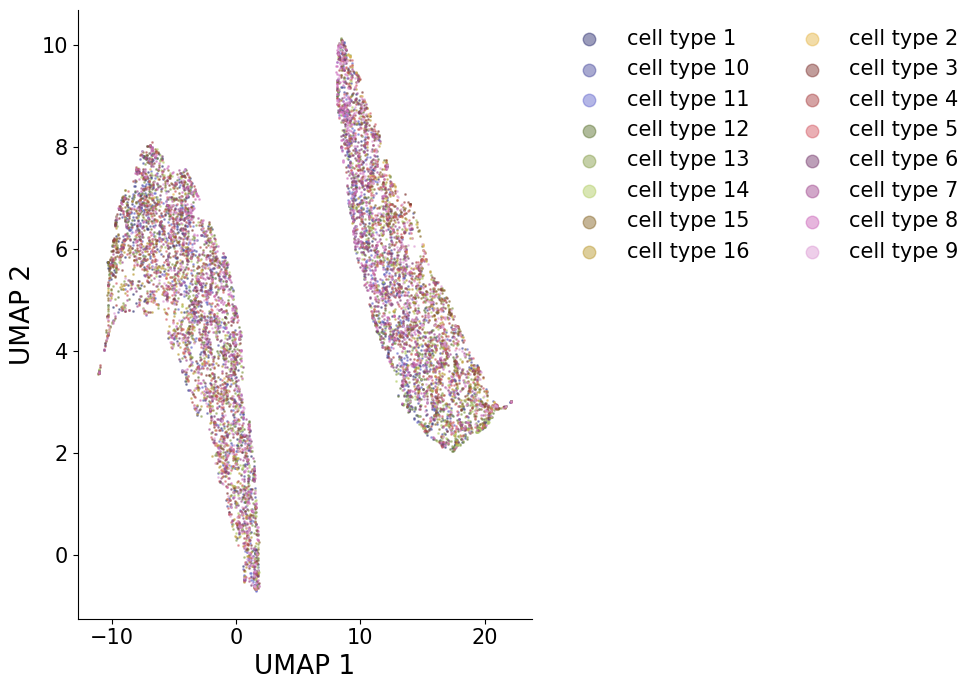

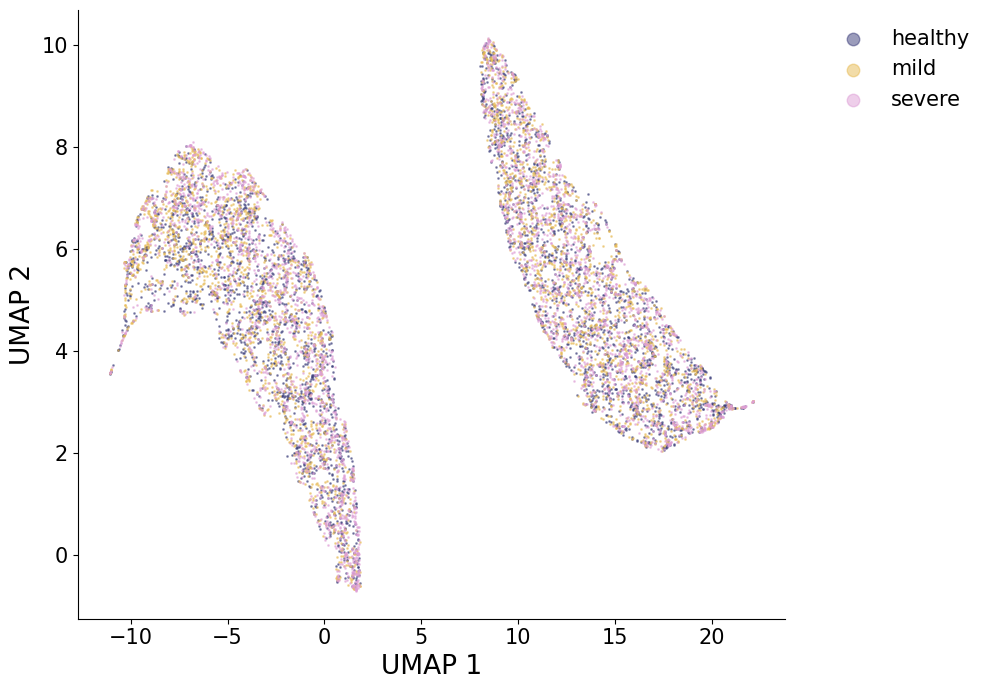

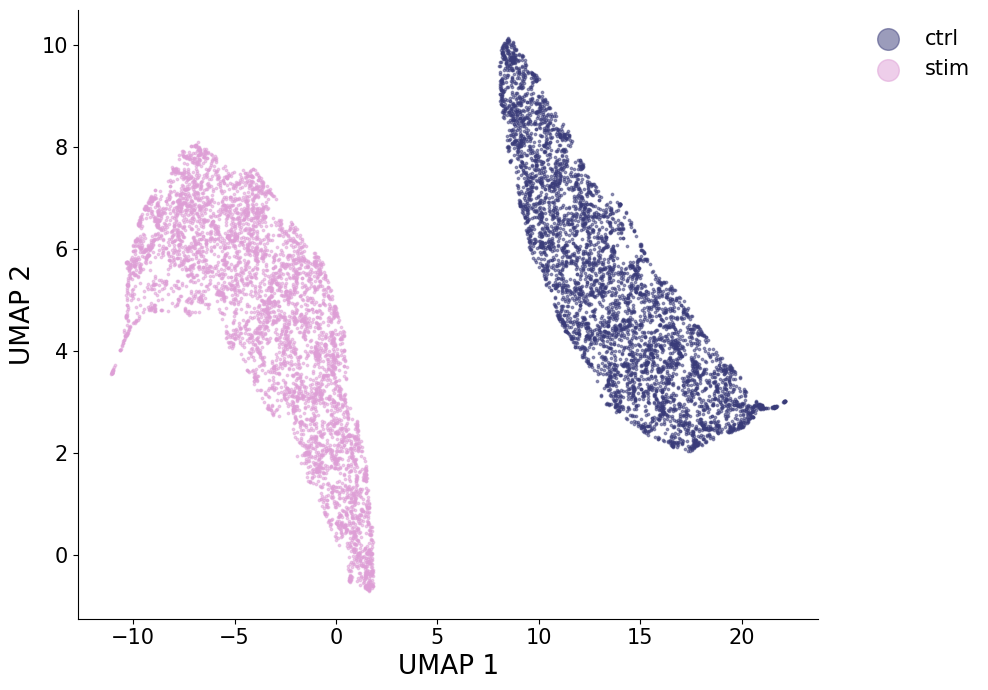

In [7]:
# Plot the result
umap_op = UMAP(min_dist = 0.1, random_state = 0)
z_cs_umap = umap_op.fit_transform(np.concatenate(z_cs, axis = 0))
z_ds_umap = []
z_ds_umap.append(umap_op.fit_transform(np.concatenate([z_d[0] for z_d in z_ds], axis = 0)))
z_ds_umap.append(umap_op.fit_transform(np.concatenate([z_d[1] for z_d in z_ds], axis = 0)))
zs_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

z_ds_umaps = [[], []]
z_cs_umaps = []
zs_umaps = []
for batch, _ in enumerate(datasets_array):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        z_ds_umaps[0].append(z_ds_umap[0][start_pointer:end_pointer,:])
        z_ds_umaps[1].append(z_ds_umap[1][start_pointer:end_pointer,:])
        z_cs_umaps.append(z_cs_umap[start_pointer:end_pointer,:])
        zs_umaps.append(zs_umap[start_pointer:end_pointer,:])

    elif batch == (len(datasets_array) - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        z_ds_umaps[0].append(z_ds_umap[0][start_pointer:,:])
        z_ds_umaps[1].append(z_ds_umap[1][start_pointer:,:])
        z_cs_umaps.append(z_cs_umap[start_pointer:,:])
        zs_umaps.append(zs_umap[start_pointer:,:])

    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        z_ds_umaps[0].append(z_ds_umap[0][start_pointer:end_pointer,:])
        z_ds_umaps[1].append(z_ds_umap[1][start_pointer:end_pointer,:])
        z_cs_umaps.append(z_cs_umap[start_pointer:end_pointer,:])
        zs_umaps.append(zs_umap[start_pointer:end_pointer,:])

comment = f'plots_{Ks}_{lambs}/'
if not os.path.exists(result_dir + comment):
    os.makedirs(result_dir + comment)


utils.plot_latent(zs = z_cs_umaps, annos = [x["batch"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"shared_batch.png") if result_dir else None , markerscale = 9, s = 1, alpha = 0.5, label_inplace = False, text_size = "small")
utils.plot_latent(zs = z_cs_umaps, annos = [x["cell_type"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"shared_celltype.png") if result_dir else None , markerscale = 9, s = 1, alpha = 0.5, label_inplace = False, text_size = "small")
utils.plot_latent(zs = z_cs_umaps, annos = [x["condition_type_1"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"shared_condition_type_1.png") if result_dir else None , markerscale = 9, s = 1, alpha = 0.5, label_inplace = False, text_size = "small")
utils.plot_latent(zs = z_cs_umaps, annos = [x["condition_type_2"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"shared_condition_type_2.png".format()) if result_dir else None, markerscale = 9, s = 3, alpha = 0.5)

utils.plot_latent(zs = z_ds_umaps[0], annos = [x["batch"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"unshared1_batch.png") if result_dir else None , markerscale = 9, s = 1, alpha = 0.5, label_inplace = False, text_size = "small")
utils.plot_latent(zs = z_ds_umaps[0], annos = [x["cell_type"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"unshared1_celltype.png") if result_dir else None , markerscale = 9, s = 1, alpha = 0.5, label_inplace = False, text_size = "small")
utils.plot_latent(zs = z_ds_umaps[0], annos = [x["condition_type_1"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"unshared1_condition_type_1.png") if result_dir else None , markerscale = 9, s = 1, alpha = 0.5, label_inplace = False, text_size = "small")
utils.plot_latent(zs = z_ds_umaps[0], annos = [x["condition_type_2"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"unshared1_condition_type_2.png".format()) if result_dir else None, markerscale = 9, s = 3, alpha = 0.5)

utils.plot_latent(zs = z_ds_umaps[1], annos = [x["batch"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"unshared2_batch.png") if result_dir else None , markerscale = 9, s = 1, alpha = 0.5, label_inplace = False, text_size = "small")
utils.plot_latent(zs = z_ds_umaps[1], annos = [x["cell_type"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"unshared2_celltype.png") if result_dir else None , markerscale = 9, s = 1, alpha = 0.5, label_inplace = False, text_size = "small")
utils.plot_latent(zs = z_ds_umaps[1], annos = [x["condition_type_1"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"unshared2_condition_type_1.png") if result_dir else None , markerscale = 9, s = 1, alpha = 0.5, label_inplace = False, text_size = "small")
utils.plot_latent(zs = z_ds_umaps[1], annos = [x["condition_type_2"].values.squeeze() for x in meta_cells_array], mode = "joint", axis_label = "UMAP", figsize = (10,7), save = (result_dir + comment+"unshared2_condition_type_2.png".format()) if result_dir else None, markerscale = 9, s = 3, alpha = 0.5)


## Key gene extraction

The condition-associated gene scores can be extracted with `model.extract_gene_scores()`. The function returns a list with length equal to the total number of condition types. The $i$th element is the scores of genes (a `np.array`) under that condition type.

In [8]:
gene_scores = model.extract_gene_scores()
# the scores of 500 genes for condition type 1
print(gene_scores[0])
# the scores of 500 genes for condition type 2
print(gene_scores[1])

[0.23173812 0.2743451  0.20706412 0.25222644 0.3852916  0.17230731
 0.17797253 0.22333284 0.29438528 0.24212058 0.28388095 0.2549247
 0.27285287 0.23596229 0.18914308 0.173875   0.24683075 0.22080134
 0.20424049 0.22668004 0.1396506  0.16211584 0.15792261 0.20092244
 0.13420422 0.13463858 0.16056776 0.1572705  0.14745812 0.14186777
 0.12456874 0.16393876 0.1454743  0.18687634 0.20096609 0.13145941
 0.17537223 0.16528516 0.14796464 0.16513589 0.15145491 0.16964786
 0.11164475 0.1604611  0.14380123 0.1454233  0.15943736 0.13926974
 0.13932064 0.15512621 0.15670694 0.13801587 0.13154286 0.12864898
 0.12981126 0.11847543 0.16034319 0.12722304 0.13232176 0.1408155
 0.17862484 0.14162152 0.17869776 0.11910398 0.14635974 0.1760453
 0.15854608 0.1408038  0.11600658 0.15602873 0.12178622 0.15233566
 0.16593525 0.15893862 0.1457288  0.15092385 0.15270281 0.13001359
 0.16044112 0.14592028 0.1407458  0.15845636 0.15915418 0.14728545
 0.1452233  0.15392156 0.15584819 0.14882576 0.16153727 0.1679862

## Prediction
Predict the count of the data under a different condition (and even remove the batch effect) with `model.predic_counts`. 
* `predict_dataset` takes as input a scDisInFact dataset that user wish to perform prediction on. 
* `predict_conds` take as input a list of predicting condition groups under each condition type.
* `predict_batch` take as input a value of the batch that the predicted count should be matched to.



For example, if we wish to predict all input count matrices under `ctrl + healthy` condition, and keey the batch effect, then we need to run

In [10]:
matching_dict

{'cond_names': [array(['healthy', 'mild', 'severe'], dtype=object),
  array(['ctrl', 'stim'], dtype=object)],
 'batch_name': array(['batch 0', 'batch 1', 'batch 2', 'batch 3', 'batch 4', 'batch 5'],
       dtype=object),
 'batch_cond_names': array(['batch 0_healthy_ctrl', 'batch 1_mild_ctrl', 'batch 2_severe_ctrl',
        'batch 3_healthy_stim', 'batch 4_mild_stim', 'batch 5_severe_stim'],
       dtype=object)}

In [11]:
pred_conds = [np.where(matching_dict["cond_names"][0] == "healthy")[0][0], np.where(matching_dict["cond_names"][1] == "ctrl")[0][0]]
X_scdisinfact_predict = []

for dataset in datasets_array:
    # predict_batch = None, keep original batch effect
    X = model.predict_counts(predict_dataset = dataset, predict_conds = pred_conds, predict_batch = None)
    X_scdisinfact_predict.append(X.detach().cpu().numpy())

X_scdisinfact_predict = np.concatenate(X_scdisinfact_predict)

If we wish to predict all input count matrices under `ctrl + healthy` condition, and remove the batch effect (map all batches to batch `0`)

In [12]:
pred_conds = [np.where(matching_dict["cond_names"][0] == "healthy")[0][0], np.where(matching_dict["cond_names"][1] == "ctrl")[0][0]]
X_scdisinfact_predict = []

for dataset in datasets_array:
    # predict_batch = 0, all match to reference batch 0
    X = model.predict_counts(predict_dataset = dataset, predict_conds = pred_conds, predict_batch = 0)
    X_scdisinfact_predict.append(X.detach().cpu().numpy())

X_scdisinfact_predict = np.concatenate(X_scdisinfact_predict)

Visualize the predicted counts

In [ ]:
X_scdisinfact_predict_norm = X_scdisinfact_predict/(np.sum(X_scdisinfact_predict, axis = 1, keepdims = True) + 1e-6) * 100
X_scdisinfact_predict_norm = np.log1p(X_scdisinfact_predict_norm)
x_pca_scdisinfact = PCA(n_components = 10).fit_transform(X_scdisinfact_predict_norm)

# plot umap
umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0) 
x_umap_scdisinfact = umap_op.fit_transform(x_pca_scdisinfact)
# separate into batches
x_umaps_scdisinfact = []
for batch, _ in enumerate(meta_cells_array):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + meta_cells_array[batch].shape[0]
        x_umaps_scdisinfact.append(x_umap_scdisinfact[start_pointer:end_pointer,:])
    elif batch == (len(meta_cells_array) - 1):
        start_pointer = start_pointer + meta_cells_array[batch - 1].shape[0]
        x_umaps_scdisinfact.append(x_umap_scdisinfact[start_pointer:,:])
    else:
        start_pointer = start_pointer + meta_cells_array[batch - 1].shape[0]
        end_pointer = start_pointer + meta_cells_array[batch].shape[0]
        x_umaps_scdisinfact.append(x_umap_scdisinfact[start_pointer:end_pointer,:])

utils.plot_latent(x_umaps_scdisinfact, annos = [x["batch"].values.squeeze() for x in meta_cells_array], mode = "joint", save = result_dir + comment + "predict_batches.png", figsize = (12,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umaps_scdisinfact, annos = [x["cell_type"].values.squeeze() for x in meta_cells_array], mode = "joint", save = result_dir + comment + "predict_celltypes.png", figsize = (11,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umaps_scdisinfact, annos = [x["condition_type_1"].values.squeeze() for x in meta_cells_array], mode = "joint", save = result_dir + comment + "predict_condition1.png", figsize = (12, 7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umaps_scdisinfact, annos = [x["condition_type_2"].values.squeeze() for x in meta_cells_array], mode = "joint", save = result_dir + comment + "predict_condition2.png", figsize = (10, 7), axis_label = "UMAP", markerscale = 6, s = 2)
